# Phân đoạn khối u trong ảnh y tế sử dụng Pre-trained Models

Notebook này thực hiện bài toán phân đoạn khối u da sử dụng:
- **Hugging Face Transformers**: Sử dụng các model như SegFormer, DETR
- **Timm**: Sử dụng các backbone pre-trained cho segmentation
- **Dataset**: ISIC (International Skin Imaging Collaboration)

## Mục tiêu
- Phân đoạn chính xác vùng khối u da trong ảnh y tế
- So sánh hiệu suất của các pre-trained models khác nhau
- Đánh giá kết quả bằng các metrics phù hợp

## 1. Import thư viện và cài đặt

In [ ]:
# # Cài đặt các thư viện cần thiết
# ! pip install transformers timm torch torchvision albumentations opencv-python-headless
# ! pip install segmentation-models-pytorch accelerate datasets
# ! pip install matplotlib seaborn scikit-learn pillow tqdm
# ! pip install gdown rarfile  # Thư viện để tải từ Google Drive và giải nén RAR
# ! pip install hf_xet  # Tối ưu tốc độ tải từ Hugging Face Hub

^C


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Hugging Face
from transformers import (
    SegformerImageProcessor, SegformerForSemanticSegmentation,
    AutoImageProcessor, AutoModelForSemanticSegmentation
)

# Timm
import timm

# Segmentation models
import segmentation_models_pytorch as smp

# Albumentations for augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Metrics
from sklearn.metrics import jaccard_score, f1_score

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 2. Tải và chuẩn bị dữ liệu

In [4]:
# Tải và giải nén dữ liệu từ Google Drive
import os
import zipfile
import gdown
from tqdm import tqdm
import platform
import subprocess

# ID file từ Google Drive link: https://drive.google.com/file/d/1IL3JPRaxhKoQMjPk_AzNK5w4OsE2gjsI/view?usp=sharing
GOOGLE_DRIVE_FILE_ID = "1IL3JPRaxhKoQMjPk_AzNK5w4OsE2gjsI"

def install_unrar_if_needed():
    """Cài đặt unrar nếu cần thiết trên Linux"""
    system = platform.system().lower()
    
    if system == 'linux':
        try:
            # Kiểm tra xem unrar đã được cài đặt chưa
            subprocess.run(['unrar'], capture_output=True, check=True)
            print("✅ unrar đã được cài đặt")
        except (subprocess.CalledProcessError, FileNotFoundError):
            print("📦 Đang cài đặt unrar...")
            try:
                # Thử cài đặt với apt (Ubuntu/Debian)
                subprocess.run(['sudo', 'apt', 'update'], check=True)
                subprocess.run(['sudo', 'apt', 'install', '-y', 'unrar'], check=True)
                print("✅ Đã cài đặt unrar thành công")
            except subprocess.CalledProcessError:
                try:
                    # Thử cài đặt với yum (CentOS/RHEL)
                    subprocess.run(['sudo', 'yum', 'install', '-y', 'unrar'], check=True)
                    print("✅ Đã cài đặt unrar thành công")
                except subprocess.CalledProcessError:
                    print("❌ Không thể cài đặt unrar tự động. Vui lòng cài đặt thủ công:")
                    print("   Ubuntu/Debian: sudo apt install unrar")
                    print("   CentOS/RHEL: sudo yum install unrar")
                    return False
    return True

def extract_archive(archive_path, extract_to):
    """Giải nén file zip hoặc rar"""
    print(f"📂 Đang giải nén {archive_path}...")
    
    if archive_path.endswith('.zip'):
        with zipfile.ZipFile(archive_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
    elif archive_path.endswith('.rar'):
        try:
            import rarfile
            with rarfile.RarFile(archive_path, 'r') as rar_ref:
                rar_ref.extractall(extract_to)
        except ImportError:
            # Fallback to command line unrar
            try:
                subprocess.run(['unrar', 'x', archive_path, extract_to], check=True)
            except (subprocess.CalledProcessError, FileNotFoundError):
                print("❌ Không thể giải nén file RAR. Cần cài đặt unrar hoặc rarfile")
                print("   Cài đặt: pip install rarfile")
                print("   Hoặc: sudo apt install unrar (Linux)")
                return False
    else:
        raise ValueError(f"Định dạng file không được hỗ trợ: {archive_path}")
    
    print(f"✅ Đã giải nén thành công vào {extract_to}")
    return True

def setup_data_structure():
    """Tạo cấu trúc thư mục data"""
    directories = [
        'data',
        'data/train',
        'data/train/images',
        'data/train/ground_truth',
        'data/val',
        'data/val/images', 
        'data/val/ground_truth',
        'data/test',
        'data/test/images',
        'data/test/ground_truth'
    ]
    
    for directory in directories:
        os.makedirs(directory, exist_ok=True)
        print(f"📁 Tạo thư mục: {directory}")

def download_and_extract_data():
    """Tải và giải nén dữ liệu từ Google Drive"""
    print("🚀 Bắt đầu tải ISIC dataset từ Google Drive...")
    print("⚠️  Lưu ý: Quá trình này có thể mất vài phút tùy thuộc vào tốc độ mạng")
    
    # Kiểm tra xem dữ liệu đã tồn tại chưa
    if os.path.exists('data/train/images') and len(os.listdir('data/train/images')) > 0:
        print("✅ Dữ liệu đã tồn tại, bỏ qua việc tải")
        return True
    
    try:
        # Cài đặt unrar nếu cần thiết (Linux)
        if not install_unrar_if_needed():
            return False
        
        # Tạo thư mục tạm
        os.makedirs('temp_downloads', exist_ok=True)
        
        # Tải file từ Google Drive
        output_path = 'temp_downloads/data.rar'
        url = f"https://drive.google.com/uc?id={GOOGLE_DRIVE_FILE_ID}"
        
        print(f"\n📥 Đang tải data.rar từ Google Drive...")
        gdown.download(url, output_path, quiet=False)
        
        if not os.path.exists(output_path):
            print("❌ Tải file thất bại!")
            return False
        
        print(f"✅ Tải file hoàn thành: {output_path}")
        
        # Tạo cấu trúc thư mục
        print("\n📁 Tạo cấu trúc thư mục...")
        setup_data_structure()
        
        # Giải nén file
        print("\n📂 Đang giải nén data.rar...")
        if not extract_archive(output_path, '.'):
            return False
        
        # Xóa file rar sau khi giải nén
        os.remove(output_path)
        
        # Xóa thư mục tạm
        try:
            os.rmdir('temp_downloads')
        except:
            pass
        
        print("\n🎉 Dataset download và extract hoàn thành!")
        print("📁 Cấu trúc dữ liệu:")
        print("   data/")
        print("   ├── train/images/")
        print("   ├── train/ground_truth/")
        print("   ├── val/images/")
        print("   ├── val/ground_truth/")
        print("   ├── test/images/")
        print("   └── test/ground_truth/")
        
        return True
        
    except Exception as e:
        print(f"❌ Lỗi: {str(e)}")
        print("\n🔧 Hướng dẫn khắc phục:")
        print("1. Kiểm tra Google Drive File ID có đúng không")
        print("2. Đảm bảo file được chia sẻ công khai")
        print("3. Kiểm tra kết nối internet")
        print("4. Thử tải thủ công và giải nén vào thư mục data/")
        return False

# Thực hiện tải và giải nén dữ liệu
if download_and_extract_data():
    print("\n📝 Bước tiếp theo:")
    print("1. Kiểm tra dữ liệu đã được tải đúng")
    print("2. Bắt đầu training models!")
else:
    print("\n❌ Tải dữ liệu thất bại. Vui lòng kiểm tra lại hoặc tải thủ công.")

🚀 Bắt đầu tải ISIC dataset từ Google Drive...
⚠️  Lưu ý: Quá trình này có thể mất vài phút tùy thuộc vào tốc độ mạng
✅ Dữ liệu đã tồn tại, bỏ qua việc tải

📝 Bước tiếp theo:
1. Kiểm tra dữ liệu đã được tải đúng
2. Bắt đầu training models!


## 3. Khám phá và kiểm tra dữ liệu

In [5]:
# Đường dẫn dữ liệu
DATA_ROOT = "data"
TRAIN_IMG_DIR = os.path.join(DATA_ROOT, "train", "images")
TRAIN_MASK_DIR = os.path.join(DATA_ROOT, "train", "ground_truth")
VAL_IMG_DIR = os.path.join(DATA_ROOT, "val", "images")
VAL_MASK_DIR = os.path.join(DATA_ROOT, "val", "ground_truth")
TEST_IMG_DIR = os.path.join(DATA_ROOT, "test", "images")
TEST_MASK_DIR = os.path.join(DATA_ROOT, "test", "ground_truth")

# Kiểm tra xem dữ liệu đã được tải chưa
if not os.path.exists(DATA_ROOT):
    print("❌ Thư mục data không tồn tại. Vui lòng chạy cell tải dữ liệu ở trên.")
else:
    # Kiểm tra số lượng file
    try:
        train_images = sorted([f for f in os.listdir(TRAIN_IMG_DIR) if f.endswith(('.jpg', '.jpeg', '.png'))])
        train_masks = sorted([f for f in os.listdir(TRAIN_MASK_DIR) if f.endswith('.png')])
        val_images = sorted([f for f in os.listdir(VAL_IMG_DIR) if f.endswith(('.jpg', '.jpeg', '.png'))])
        val_masks = sorted([f for f in os.listdir(VAL_MASK_DIR) if f.endswith('.png')])
        
        print(f"📊 Thống kê dữ liệu:")
        print(f"   Training images: {len(train_images)}")
        print(f"   Training masks: {len(train_masks)}")
        print(f"   Validation images: {len(val_images)}")
        print(f"   Validation masks: {len(val_masks)}")
        
        # Kiểm tra test set nếu có
        if os.path.exists(TEST_IMG_DIR):
            test_images = sorted([f for f in os.listdir(TEST_IMG_DIR) if f.endswith(('.jpg', '.jpeg', '.png'))])
            test_masks = sorted([f for f in os.listdir(TEST_MASK_DIR) if f.endswith('.png')])
            print(f"   Test images: {len(test_images)}")
            print(f"   Test masks: {len(test_masks)}")
        
        # Kiểm tra tương ứng giữa image và mask
        def check_correspondence(images, masks):
            if len(images) == 0 or len(masks) == 0:
                return False
            img_ids = [img.split('.')[0] for img in images]
            # Thử nhiều pattern khác nhau cho mask names
            mask_ids = []
            for mask in masks:
                mask_name = mask.split('.')[0]
                # Thử loại bỏ các suffix phổ biến
                for suffix in ['_segmentation', '_mask', '_gt', '_label']:
                    if mask_name.endswith(suffix):
                        mask_name = mask_name[:-len(suffix)]
                        break
                mask_ids.append(mask_name)
            
            return len(set(img_ids).intersection(set(mask_ids))) > 0
        
        print(f"\n🔍 Kiểm tra tương ứng dữ liệu:")
        train_match = check_correspondence(train_images, train_masks)
        val_match = check_correspondence(val_images, val_masks)
        print(f"   Train correspondence: {'✅' if train_match else '❌'} {train_match}")
        print(f"   Val correspondence: {'✅' if val_match else '❌'} {val_match}")
        
        if train_match and val_match:
            print("\n🎉 Dữ liệu đã sẵn sàng để training!")
        else:
            print("\n⚠️  Có vấn đề với tương ứng giữa images và masks. Kiểm tra lại cấu trúc dữ liệu.")
            
    except FileNotFoundError as e:
        print(f"❌ Không tìm thấy thư mục: {e}")
        print("   Vui lòng kiểm tra lại việc tải và giải nén dữ liệu.")

📊 Thống kê dữ liệu:
   Training images: 2594
   Training masks: 2594
   Validation images: 100
   Validation masks: 100
   Test images: 1000
   Test masks: 1000

🔍 Kiểm tra tương ứng dữ liệu:
   Train correspondence: ✅ True
   Val correspondence: ✅ True

🎉 Dữ liệu đã sẵn sàng để training!


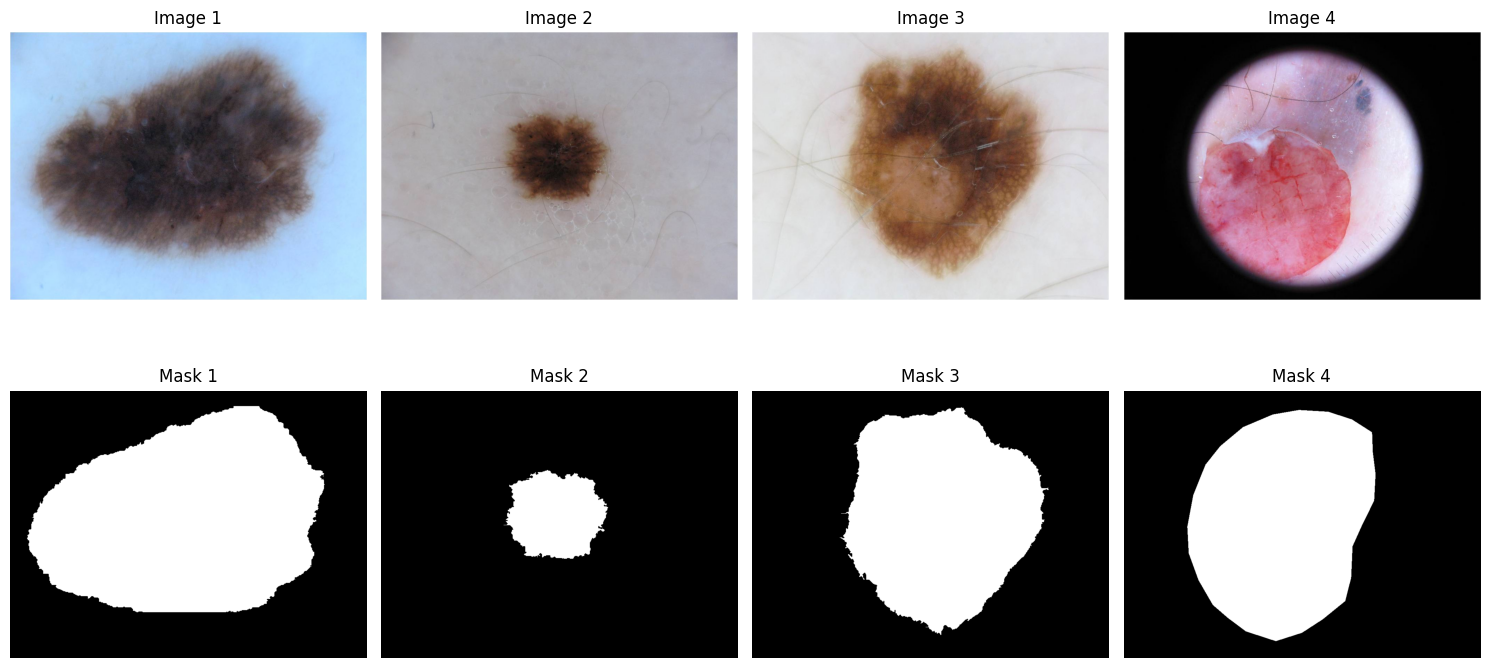

In [6]:
# Hiển thị một vài mẫu dữ liệu
def visualize_samples(img_dir, mask_dir, images, masks, num_samples=4):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 8))
    
    for i in range(num_samples):
        # Load image
        img_path = os.path.join(img_dir, images[i])
        image = Image.open(img_path).convert('RGB')
        
        # Load mask
        mask_name = images[i].split('.')[0] + '_segmentation.png'
        mask_path = os.path.join(mask_dir, mask_name)
        mask = Image.open(mask_path).convert('L')
        
        # Display
        axes[0, i].imshow(image)
        axes[0, i].set_title(f'Image {i+1}')
        axes[0, i].axis('off')
        
        axes[1, i].imshow(mask, cmap='gray')
        axes[1, i].set_title(f'Mask {i+1}')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_samples(TRAIN_IMG_DIR, TRAIN_MASK_DIR, train_images, train_masks)

## 3. Dataset và Data Augmentation

In [7]:
class ISICDataset(Dataset):
    def __init__(self, img_dir, mask_dir, images, transform=None, target_size=(512, 512)):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.images = images
        self.transform = transform
        self.target_size = target_size
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Load image
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Load mask
        mask_name = img_name.split('.')[0] + '_segmentation.png'
        mask_path = os.path.join(self.mask_dir, mask_name)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Resize
        image = cv2.resize(image, self.target_size)
        mask = cv2.resize(mask, self.target_size)
        
        # Normalize mask to 0-1
        mask = (mask > 127).astype(np.float32)
        
        # Apply transforms
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        return image, mask.unsqueeze(0)  # Add channel dimension to mask

In [8]:
# Define augmentations
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Create datasets
train_dataset = ISICDataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR, train_images, train_transform)
val_dataset = ISICDataset(VAL_IMG_DIR, VAL_MASK_DIR, val_images, val_transform)

# Create test dataset
test_images = sorted([f for f in os.listdir(TEST_IMG_DIR) if f.endswith('.jpg')])
test_dataset = ISICDataset(TEST_IMG_DIR, TEST_MASK_DIR, test_images, val_transform)

# Create data loaders
BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 325
Val batches: 13
Test batches: 125


## 4. Model Definitions

### 4.1 SegFormer từ Hugging Face

In [9]:
class SegFormerModel(nn.Module):
    def __init__(self, model_name="nvidia/segformer-b0-finetuned-ade-512-512", num_classes=1):
        super().__init__()
        self.processor = SegformerImageProcessor.from_pretrained(model_name)
        self.model = SegformerForSemanticSegmentation.from_pretrained(
            model_name,
            num_labels=num_classes,
            ignore_mismatched_sizes=True
        )
        
    def forward(self, x):
        # SegFormer expects input in range [0, 1]
        # Denormalize from ImageNet normalization
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(x.device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(x.device)
        x_denorm = x * std + mean
        
        outputs = self.model(pixel_values=x_denorm)
        logits = outputs.logits
        
        # Resize to input size
        logits = F.interpolate(logits, size=x.shape[-2:], mode='bilinear', align_corners=False)
        
        return torch.sigmoid(logits)  # Apply sigmoid for binary segmentation

### 4.2 U-Net với EfficientNet Backbone

In [10]:
class TimmUNet(nn.Module):
    def __init__(self, backbone_name="efficientnet-b0", num_classes=1, pretrained=True):
        super().__init__()
        self.model = smp.Unet(
            encoder_name=backbone_name,
            encoder_weights="imagenet" if pretrained else None,
            in_channels=3,
            classes=num_classes,
            activation=None  # We'll apply sigmoid manually
        )
        
    def forward(self, x):
        return torch.sigmoid(self.model(x))

### 4.3 Vision Transformer (ViT) Segmentation

In [11]:
from transformers import ViTModel, ViTConfig

class ViTSegmentation(nn.Module):
    def __init__(self, model_name="google/vit-base-patch16-224", num_classes=1, img_size=512):
        super().__init__()
        
        # Load pre-trained ViT
        self.vit = ViTModel.from_pretrained(model_name)
        self.config = self.vit.config
        
        # Modify patch size for higher resolution if needed
        self.img_size = img_size
        self.patch_size = self.config.patch_size
        self.num_patches = (img_size // self.patch_size) ** 2
        
        # Segmentation head
        hidden_size = self.config.hidden_size
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, self.patch_size * self.patch_size * num_classes)
        )
        
        # Upsampling layers for final output
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1)
        )
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        # ViT forward pass
        outputs = self.vit(pixel_values=x)
        
        # Get patch embeddings (exclude CLS token)
        patch_embeddings = outputs.last_hidden_state[:, 1:, :]  # [B, num_patches, hidden_size]
        
        # Decode to patch-level predictions
        decoded = self.decoder(patch_embeddings)  # [B, num_patches, patch_size^2 * num_classes]
        
        # Reshape to spatial format
        patches_per_side = int(self.num_patches ** 0.5)
        decoded = decoded.view(batch_size, patches_per_side, patches_per_side, 
                              self.patch_size, self.patch_size, -1)
        
        # Rearrange patches to form image
        decoded = decoded.permute(0, 5, 1, 3, 2, 4).contiguous()
        decoded = decoded.view(batch_size, -1, 
                              patches_per_side * self.patch_size, 
                              patches_per_side * self.patch_size)
        
        # Upsample to original resolution
        output = self.upsample(decoded)
        
        # Resize to exact target size if needed
        if output.shape[-1] != self.img_size:
            output = F.interpolate(output, size=(self.img_size, self.img_size), 
                                 mode='bilinear', align_corners=False)
        
        return torch.sigmoid(output)

### 4.4 U-Net với ViT Backbone

In [12]:
class ViTUNet(nn.Module):
    def __init__(self, backbone_name="vit_base_patch16_224", num_classes=1, pretrained=True):
        super().__init__()
        self.model = smp.Unet(
            encoder_name=backbone_name,
            encoder_weights="imagenet" if pretrained else None,
            in_channels=3,
            classes=num_classes,
            activation=None
        )
        
    def forward(self, x):
        return torch.sigmoid(self.model(x))

### 4.5 DeepLabV3+ với Timm Backbone

In [13]:
class TimmDeepLabV3Plus(nn.Module):
    def __init__(self, backbone_name="resnet50", num_classes=1, pretrained=True):
        super().__init__()
        self.model = smp.DeepLabV3Plus(
            encoder_name=backbone_name,
            encoder_weights="imagenet" if pretrained else None,
            in_channels=3,
            classes=num_classes,
            activation=None
        )
        
    def forward(self, x):
        return torch.sigmoid(self.model(x))

## 5. Loss Functions và Metrics

In [14]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
        
    def forward(self, pred, target):
        pred = pred.view(-1)
        target = target.view(-1)
        
        intersection = (pred * target).sum()
        dice = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
        
        return 1 - dice

class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super().__init__()
        self.alpha = alpha
        self.bce = nn.BCELoss()
        self.dice = DiceLoss()
        
    def forward(self, pred, target):
        return self.alpha * self.bce(pred, target) + (1 - self.alpha) * self.dice(pred, target)

def calculate_iou(pred, target, threshold=0.5):
    pred_binary = (pred > threshold).float()
    target_binary = target.float()
    
    intersection = (pred_binary * target_binary).sum()
    union = pred_binary.sum() + target_binary.sum() - intersection
    
    iou = intersection / (union + 1e-6)
    return iou.item()

def calculate_dice(pred, target, threshold=0.5):
    pred_binary = (pred > threshold).float()
    target_binary = target.float()
    
    intersection = (pred_binary * target_binary).sum()
    dice = (2. * intersection) / (pred_binary.sum() + target_binary.sum() + 1e-6)
    
    return dice.item()

## 6. Training Functions

In [15]:
def train_model(model, train_loader, val_loader, num_epochs=15, lr=1e-4, scheduler_type='plateau'):
    """
    Training function for segmentation models with comprehensive metrics
    
    Args:
        model: PyTorch model
        train_loader: Training data loader
        val_loader: Validation data loader
        num_epochs: Number of training epochs
        lr: Learning rate
        scheduler_type: 'plateau', 'cosine', 'step', or 'exponential'
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Loss function and optimizer
    criterion = CombinedLoss(alpha=0.5)  # Combination of BCE and Dice loss
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    
    # Learning rate scheduler
    if scheduler_type == 'plateau':
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
    elif scheduler_type == 'cosine':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=lr*0.01)
    elif scheduler_type == 'step':
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=num_epochs//3, gamma=0.1)
    elif scheduler_type == 'exponential':
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    else:
        scheduler = None
    
    # Training history with comprehensive metrics
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_dice': [],
        'val_dice': [],
        'train_jaccard': [],
        'val_jaccard': [],
        'learning_rates': []
    }
    
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_dice = 0.0
        train_jaccard = 0.0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training')
        for batch_idx, (images, masks) in enumerate(train_pbar):
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            # Calculate metrics
            with torch.no_grad():
                pred_masks = outputs > 0.5  # outputs already have sigmoid applied
                dice = calculate_dice_batch(outputs, masks)
                jaccard = calculate_jaccard_batch(pred_masks, masks.bool())
                train_dice += dice
                train_jaccard += jaccard
            
            train_loss += loss.item()
            train_pbar.set_postfix({
                'Loss': loss.item(), 
                'Dice': dice, 
                'Jaccard': jaccard
            })
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        val_jaccard = 0.0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation')
            for images, masks in val_pbar:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                # Calculate metrics
                pred_masks = outputs > 0.5  # outputs already have sigmoid applied
                dice = calculate_dice_batch(outputs, masks)
                jaccard = calculate_jaccard_batch(pred_masks, masks.bool())
                val_dice += dice
                val_jaccard += jaccard
                
                val_loss += loss.item()
                val_pbar.set_postfix({
                    'Loss': loss.item(), 
                    'Dice': dice, 
                    'Jaccard': jaccard
                })
        
        # Calculate average metrics
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_train_dice = train_dice / len(train_loader)
        avg_val_dice = val_dice / len(val_loader)
        avg_train_jaccard = train_jaccard / len(train_loader)
        avg_val_jaccard = val_jaccard / len(val_loader)
        
        # Update history
        history['train_losses'].append(avg_train_loss)
        history['val_losses'].append(avg_val_loss)
        history['train_dice'].append(avg_train_dice)
        history['val_dice'].append(avg_val_dice)
        history['train_jaccard'].append(avg_train_jaccard)
        history['val_jaccard'].append(avg_val_jaccard)
        history['learning_rates'].append(optimizer.param_groups[0]['lr'])
        
        # Learning rate scheduling
        old_lr = optimizer.param_groups[0]['lr']
        if scheduler_type == 'plateau':
            scheduler.step(avg_val_loss)
        elif scheduler is not None:
            scheduler.step()
        
        # Check if learning rate changed
        new_lr = optimizer.param_groups[0]['lr']
        if old_lr != new_lr:
            print(f'  Learning rate changed: {old_lr:.6f} -> {new_lr:.6f}')
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {avg_train_loss:.4f}, Train Dice: {avg_train_dice:.4f}, Train Jaccard: {avg_train_jaccard:.4f}')
        print(f'  Val Loss: {avg_val_loss:.4f}, Val Dice: {avg_val_dice:.4f}, Val Jaccard: {avg_val_jaccard:.4f}')
        print(f'  LR: {optimizer.param_groups[0]["lr"]:.6f}')
        print('-' * 70)
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            print(f'New best validation loss: {best_val_loss:.4f}')
    
    return history

def calculate_iou_batch(pred_masks, true_masks):
    """
    Calculate Intersection over Union (IoU) for batch of masks
    """
    intersection = (pred_masks & true_masks).float().sum((1, 2, 3))
    union = (pred_masks | true_masks).float().sum((1, 2, 3))
    
    # Avoid division by zero
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean().item()

def calculate_dice_batch(pred_probs, true_masks):
    """
    Calculate Dice Coefficient for batch of masks
    pred_probs: predicted probabilities (after sigmoid)
    true_masks: ground truth binary masks
    """
    pred_flat = pred_probs.view(pred_probs.size(0), -1)
    true_flat = true_masks.view(true_masks.size(0), -1)
    
    intersection = (pred_flat * true_flat).sum(dim=1)
    dice = (2. * intersection + 1e-6) / (pred_flat.sum(dim=1) + true_flat.sum(dim=1) + 1e-6)
    
    return dice.mean().item()

def calculate_jaccard_batch(pred_masks, true_masks):
    """
    Calculate Jaccard Index (IoU) for batch of masks
    Same as IoU but with different name for clarity
    """
    return calculate_iou_batch(pred_masks, true_masks)

## 7. Training Models

### 7.1 Training SegFormer từ Hugging Face

In [ ]:
# Initialize SegFormer model
print("Training SegFormer model...")
segformer_model = SegFormerModel(
    model_name="nvidia/segformer-b0-finetuned-ade-512-512",
    num_classes=1
)

# Train the model
segformer_history = train_model(
    segformer_model, 
    train_loader, 
    val_loader, 
    num_epochs=20, 
    lr=5e-5,  # Lower learning rate for pre-trained transformer
    scheduler_type='cosine'  # Cosine annealing for transformer
)

# Save the trained model
os.makedirs('models', exist_ok=True)
torch.save(segformer_model.state_dict(), 'models/segformer_model.pth')
print("SegFormer training completed!")

Training SegFormer model...


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([1]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([1, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/20 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.21it/s, Loss=0.222, Dice=0.664, Jaccard=0.711]


  Learning rate changed: 0.000050 -> 0.000050
Epoch 1/20:
  Train Loss: 0.3538, Train Dice: 0.4977, Train Jaccard: 0.6697
  Val Loss: 0.2321, Val Dice: 0.6893, Val Jaccard: 0.7365
  LR: 0.000050
----------------------------------------------------------------------
New best validation loss: 0.2321


Epoch 2/20 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.20it/s, Loss=0.155, Dice=0.771, Jaccard=0.741]


  Learning rate changed: 0.000050 -> 0.000049
Epoch 2/20:
  Train Loss: 0.2121, Train Dice: 0.6418, Train Jaccard: 0.7472
  Val Loss: 0.1631, Val Dice: 0.7862, Val Jaccard: 0.7800
  LR: 0.000049
----------------------------------------------------------------------
New best validation loss: 0.1631


Epoch 3/20 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.26it/s, Loss=0.112, Dice=0.826, Jaccard=0.785] 


  Learning rate changed: 0.000049 -> 0.000047
Epoch 3/20:
  Train Loss: 0.1641, Train Dice: 0.7162, Train Jaccard: 0.7751
  Val Loss: 0.1330, Val Dice: 0.8295, Val Jaccard: 0.8144
  LR: 0.000047
----------------------------------------------------------------------
New best validation loss: 0.1330


Epoch 4/20 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.15it/s, Loss=0.162, Dice=0.806, Jaccard=0.737]


  Learning rate changed: 0.000047 -> 0.000045
Epoch 4/20:
  Train Loss: 0.1406, Train Dice: 0.7659, Train Jaccard: 0.7951
  Val Loss: 0.1687, Val Dice: 0.8225, Val Jaccard: 0.7786
  LR: 0.000045
----------------------------------------------------------------------


Epoch 5/20 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.22it/s, Loss=0.146, Dice=0.826, Jaccard=0.748] 


  Learning rate changed: 0.000045 -> 0.000043
Epoch 5/20:
  Train Loss: 0.1274, Train Dice: 0.7978, Train Jaccard: 0.8054
  Val Loss: 0.1422, Val Dice: 0.8472, Val Jaccard: 0.8044
  LR: 0.000043
----------------------------------------------------------------------


Epoch 6/20 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.18it/s, Loss=0.155, Dice=0.833, Jaccard=0.747] 


  Learning rate changed: 0.000043 -> 0.000040
Epoch 6/20:
  Train Loss: 0.1212, Train Dice: 0.8132, Train Jaccard: 0.8087
  Val Loss: 0.1318, Val Dice: 0.8604, Val Jaccard: 0.8114
  LR: 0.000040
----------------------------------------------------------------------
New best validation loss: 0.1318


Epoch 7/20 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.18it/s, Loss=0.136, Dice=0.838, Jaccard=0.757] 


  Learning rate changed: 0.000040 -> 0.000036
Epoch 7/20:
  Train Loss: 0.1143, Train Dice: 0.8266, Train Jaccard: 0.8129
  Val Loss: 0.1253, Val Dice: 0.8622, Val Jaccard: 0.8198
  LR: 0.000036
----------------------------------------------------------------------
New best validation loss: 0.1253


Epoch 8/20 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.10it/s, Loss=0.179, Dice=0.809, Jaccard=0.715]


  Learning rate changed: 0.000036 -> 0.000033
Epoch 8/20:
  Train Loss: 0.1100, Train Dice: 0.8361, Train Jaccard: 0.8165
  Val Loss: 0.1662, Val Dice: 0.8403, Val Jaccard: 0.7768
  LR: 0.000033
----------------------------------------------------------------------


Epoch 9/20 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.19it/s, Loss=0.143, Dice=0.847, Jaccard=0.761]


  Learning rate changed: 0.000033 -> 0.000029
Epoch 9/20:
  Train Loss: 0.1087, Train Dice: 0.8417, Train Jaccard: 0.8189
  Val Loss: 0.1341, Val Dice: 0.8655, Val Jaccard: 0.8110
  LR: 0.000029
----------------------------------------------------------------------


Epoch 10/20 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.24it/s, Loss=0.14, Dice=0.851, Jaccard=0.763]  


  Learning rate changed: 0.000029 -> 0.000025
Epoch 10/20:
  Train Loss: 0.1034, Train Dice: 0.8513, Train Jaccard: 0.8258
  Val Loss: 0.1343, Val Dice: 0.8691, Val Jaccard: 0.8113
  LR: 0.000025
----------------------------------------------------------------------


Epoch 11/20 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.15it/s, Loss=0.17, Dice=0.827, Jaccard=0.735]  


  Learning rate changed: 0.000025 -> 0.000021
Epoch 11/20:
  Train Loss: 0.1042, Train Dice: 0.8519, Train Jaccard: 0.8236
  Val Loss: 0.1486, Val Dice: 0.8535, Val Jaccard: 0.7970
  LR: 0.000021
----------------------------------------------------------------------


Epoch 12/20 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.04it/s, Loss=0.134, Dice=0.859, Jaccard=0.775] 


  Learning rate changed: 0.000021 -> 0.000018
Epoch 12/20:
  Train Loss: 0.0993, Train Dice: 0.8593, Train Jaccard: 0.8303
  Val Loss: 0.1264, Val Dice: 0.8754, Val Jaccard: 0.8235
  LR: 0.000018
----------------------------------------------------------------------


Epoch 13/20 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.10it/s, Loss=0.175, Dice=0.834, Jaccard=0.74]  


  Learning rate changed: 0.000018 -> 0.000014
Epoch 13/20:
  Train Loss: 0.0952, Train Dice: 0.8651, Train Jaccard: 0.8342
  Val Loss: 0.1486, Val Dice: 0.8629, Val Jaccard: 0.8033
  LR: 0.000014
----------------------------------------------------------------------


Epoch 14/20 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.14it/s, Loss=0.148, Dice=0.85, Jaccard=0.76]   


  Learning rate changed: 0.000014 -> 0.000011
Epoch 14/20:
  Train Loss: 0.0954, Train Dice: 0.8645, Train Jaccard: 0.8338
  Val Loss: 0.1302, Val Dice: 0.8725, Val Jaccard: 0.8156
  LR: 0.000011
----------------------------------------------------------------------


Epoch 15/20 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.09it/s, Loss=0.147, Dice=0.851, Jaccard=0.76]  


  Learning rate changed: 0.000011 -> 0.000008
Epoch 15/20:
  Train Loss: 0.0950, Train Dice: 0.8654, Train Jaccard: 0.8330
  Val Loss: 0.1361, Val Dice: 0.8727, Val Jaccard: 0.8122
  LR: 0.000008
----------------------------------------------------------------------


Epoch 16/20 - Validation: 100%|██████████| 13/13 [00:04<00:00,  2.95it/s, Loss=0.145, Dice=0.851, Jaccard=0.761] 


  Learning rate changed: 0.000008 -> 0.000005
Epoch 16/20:
  Train Loss: 0.0919, Train Dice: 0.8696, Train Jaccard: 0.8362
  Val Loss: 0.1283, Val Dice: 0.8752, Val Jaccard: 0.8191
  LR: 0.000005
----------------------------------------------------------------------


Epoch 17/20 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.14it/s, Loss=0.154, Dice=0.845, Jaccard=0.755] 


  Learning rate changed: 0.000005 -> 0.000003
Epoch 17/20:
  Train Loss: 0.0905, Train Dice: 0.8710, Train Jaccard: 0.8393
  Val Loss: 0.1418, Val Dice: 0.8692, Val Jaccard: 0.8095
  LR: 0.000003
----------------------------------------------------------------------


Epoch 18/20 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.15it/s, Loss=0.149, Dice=0.847, Jaccard=0.756] 


  Learning rate changed: 0.000003 -> 0.000002
Epoch 18/20:
  Train Loss: 0.0911, Train Dice: 0.8720, Train Jaccard: 0.8394
  Val Loss: 0.1329, Val Dice: 0.8726, Val Jaccard: 0.8136
  LR: 0.000002
----------------------------------------------------------------------


Epoch 19/20 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.06it/s, Loss=0.149, Dice=0.847, Jaccard=0.755] 


  Learning rate changed: 0.000002 -> 0.000001
Epoch 19/20:
  Train Loss: 0.0889, Train Dice: 0.8733, Train Jaccard: 0.8404
  Val Loss: 0.1335, Val Dice: 0.8725, Val Jaccard: 0.8122
  LR: 0.000001
----------------------------------------------------------------------


Epoch 20/20 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.14it/s, Loss=0.162, Dice=0.841, Jaccard=0.747] 

  Learning rate changed: 0.000001 -> 0.000001
Epoch 20/20:
  Train Loss: 0.0893, Train Dice: 0.8736, Train Jaccard: 0.8413
  Val Loss: 0.1413, Val Dice: 0.8693, Val Jaccard: 0.8066
  LR: 0.000001
----------------------------------------------------------------------
SegFormer training completed!


### 7.2 Training U-Net với EfficientNet backbone

In [ ]:
# Initialize U-Net model with EfficientNet backbone
print("Training U-Net with EfficientNet backbone...")
unet_model = TimmUNet(
    backbone_name="efficientnet-b0",
    num_classes=1,
    pretrained=True
)

# Train the model
unet_history = train_model(
    unet_model, 
    train_loader, 
    val_loader, 
    num_epochs=25, 
    lr=1e-4,
    scheduler_type='plateau'  # ReduceLROnPlateau for U-Net
)

# Save the trained model
torch.save(unet_model.state_dict(), 'models/unet_efficientnet_model.pth')
print("U-Net training completed!")

Training U-Net with EfficientNet backbone...


Epoch 1/25 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.15it/s, Loss=0.191, Dice=0.717, Jaccard=0.738]


Epoch 1/25:
  Train Loss: 0.3247, Train Dice: 0.5404, Train Jaccard: 0.6373
  Val Loss: 0.2225, Val Dice: 0.7288, Val Jaccard: 0.7626
  LR: 0.000100
----------------------------------------------------------------------
New best validation loss: 0.2225


Epoch 2/25 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.11it/s, Loss=0.195, Dice=0.761, Jaccard=0.695]


Epoch 2/25:
  Train Loss: 0.1850, Train Dice: 0.7097, Train Jaccard: 0.7527
  Val Loss: 0.1745, Val Dice: 0.7996, Val Jaccard: 0.7665
  LR: 0.000100
----------------------------------------------------------------------
New best validation loss: 0.1745


Epoch 3/25 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.11it/s, Loss=0.141, Dice=0.815, Jaccard=0.759] 


Epoch 3/25:
  Train Loss: 0.1575, Train Dice: 0.7676, Train Jaccard: 0.7721
  Val Loss: 0.1569, Val Dice: 0.8348, Val Jaccard: 0.8003
  LR: 0.000100
----------------------------------------------------------------------
New best validation loss: 0.1569


Epoch 4/25 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.11it/s, Loss=0.141, Dice=0.824, Jaccard=0.748] 


Epoch 4/25:
  Train Loss: 0.1368, Train Dice: 0.8039, Train Jaccard: 0.7944
  Val Loss: 0.1647, Val Dice: 0.8397, Val Jaccard: 0.7968
  LR: 0.000100
----------------------------------------------------------------------


Epoch 5/25 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.12it/s, Loss=0.15, Dice=0.823, Jaccard=0.744]  


Epoch 5/25:
  Train Loss: 0.1198, Train Dice: 0.8273, Train Jaccard: 0.8093
  Val Loss: 0.1515, Val Dice: 0.8480, Val Jaccard: 0.8079
  LR: 0.000100
----------------------------------------------------------------------
New best validation loss: 0.1515


Epoch 6/25 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.09it/s, Loss=0.148, Dice=0.835, Jaccard=0.754] 


Epoch 6/25:
  Train Loss: 0.1138, Train Dice: 0.8442, Train Jaccard: 0.8177
  Val Loss: 0.1602, Val Dice: 0.8537, Val Jaccard: 0.8056
  LR: 0.000100
----------------------------------------------------------------------


Epoch 7/25 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.08it/s, Loss=0.171, Dice=0.818, Jaccard=0.734]


Epoch 7/25:
  Train Loss: 0.1102, Train Dice: 0.8489, Train Jaccard: 0.8188
  Val Loss: 0.1589, Val Dice: 0.8547, Val Jaccard: 0.7927
  LR: 0.000100
----------------------------------------------------------------------


Epoch 8/25 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.15it/s, Loss=0.166, Dice=0.82, Jaccard=0.729]  


Epoch 8/25:
  Train Loss: 0.1071, Train Dice: 0.8572, Train Jaccard: 0.8253
  Val Loss: 0.1597, Val Dice: 0.8546, Val Jaccard: 0.8011
  LR: 0.000100
----------------------------------------------------------------------


Epoch 9/25 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.02it/s, Loss=0.141, Dice=0.85, Jaccard=0.763] 


  Learning rate changed: 0.000100 -> 0.000050
Epoch 9/25:
  Train Loss: 0.1050, Train Dice: 0.8609, Train Jaccard: 0.8248
  Val Loss: 0.1810, Val Dice: 0.8404, Val Jaccard: 0.7834
  LR: 0.000050
----------------------------------------------------------------------


Epoch 10/25 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.08it/s, Loss=0.155, Dice=0.841, Jaccard=0.747] 


Epoch 10/25:
  Train Loss: 0.0957, Train Dice: 0.8698, Train Jaccard: 0.8356
  Val Loss: 0.1529, Val Dice: 0.8642, Val Jaccard: 0.8026
  LR: 0.000050
----------------------------------------------------------------------


Epoch 11/25 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.07it/s, Loss=0.126, Dice=0.872, Jaccard=0.795]


Epoch 11/25:
  Train Loss: 0.0938, Train Dice: 0.8721, Train Jaccard: 0.8382
  Val Loss: 0.1417, Val Dice: 0.8793, Val Jaccard: 0.8259
  LR: 0.000050
----------------------------------------------------------------------
New best validation loss: 0.1417


Epoch 12/25 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.12it/s, Loss=0.159, Dice=0.86, Jaccard=0.78]   


Epoch 12/25:
  Train Loss: 0.0915, Train Dice: 0.8764, Train Jaccard: 0.8399
  Val Loss: 0.1471, Val Dice: 0.8770, Val Jaccard: 0.8236
  LR: 0.000050
----------------------------------------------------------------------


Epoch 13/25 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.03it/s, Loss=0.193, Dice=0.835, Jaccard=0.739] 


Epoch 13/25:
  Train Loss: 0.0897, Train Dice: 0.8807, Train Jaccard: 0.8429
  Val Loss: 0.1591, Val Dice: 0.8654, Val Jaccard: 0.8029
  LR: 0.000050
----------------------------------------------------------------------


Epoch 14/25 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.12it/s, Loss=0.142, Dice=0.855, Jaccard=0.767] 


Epoch 14/25:
  Train Loss: 0.0895, Train Dice: 0.8803, Train Jaccard: 0.8438
  Val Loss: 0.1458, Val Dice: 0.8660, Val Jaccard: 0.8082
  LR: 0.000050
----------------------------------------------------------------------


Epoch 15/25 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.05it/s, Loss=0.141, Dice=0.85, Jaccard=0.765]  


Epoch 15/25:
  Train Loss: 0.0888, Train Dice: 0.8828, Train Jaccard: 0.8434
  Val Loss: 0.1360, Val Dice: 0.8745, Val Jaccard: 0.8181
  LR: 0.000050
----------------------------------------------------------------------
New best validation loss: 0.1360


Epoch 16/25 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.08it/s, Loss=0.133, Dice=0.857, Jaccard=0.78]  


Epoch 16/25:
  Train Loss: 0.0898, Train Dice: 0.8816, Train Jaccard: 0.8419
  Val Loss: 0.1403, Val Dice: 0.8732, Val Jaccard: 0.8219
  LR: 0.000050
----------------------------------------------------------------------


Epoch 17/25 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.13it/s, Loss=0.131, Dice=0.873, Jaccard=0.802] 


Epoch 17/25:
  Train Loss: 0.0867, Train Dice: 0.8847, Train Jaccard: 0.8446
  Val Loss: 0.1435, Val Dice: 0.8703, Val Jaccard: 0.8216
  LR: 0.000050
----------------------------------------------------------------------


Epoch 18/25 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.08it/s, Loss=0.132, Dice=0.862, Jaccard=0.786] 


Epoch 18/25:
  Train Loss: 0.0836, Train Dice: 0.8869, Train Jaccard: 0.8473
  Val Loss: 0.1312, Val Dice: 0.8788, Val Jaccard: 0.8276
  LR: 0.000050
----------------------------------------------------------------------
New best validation loss: 0.1312


Epoch 19/25 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.06it/s, Loss=0.145, Dice=0.856, Jaccard=0.77]  


Epoch 19/25:
  Train Loss: 0.0838, Train Dice: 0.8887, Train Jaccard: 0.8491
  Val Loss: 0.1513, Val Dice: 0.8712, Val Jaccard: 0.8131
  LR: 0.000050
----------------------------------------------------------------------


Epoch 20/25 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.11it/s, Loss=0.15, Dice=0.862, Jaccard=0.776] 


Epoch 20/25:
  Train Loss: 0.0859, Train Dice: 0.8862, Train Jaccard: 0.8460
  Val Loss: 0.1603, Val Dice: 0.8737, Val Jaccard: 0.8162
  LR: 0.000050
----------------------------------------------------------------------


Epoch 21/25 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.22it/s, Loss=0.166, Dice=0.861, Jaccard=0.775] 


Epoch 21/25:
  Train Loss: 0.0824, Train Dice: 0.8897, Train Jaccard: 0.8490
  Val Loss: 0.1552, Val Dice: 0.8750, Val Jaccard: 0.8136
  LR: 0.000050
----------------------------------------------------------------------


Epoch 22/25 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.10it/s, Loss=0.18, Dice=0.85, Jaccard=0.757]   


  Learning rate changed: 0.000050 -> 0.000025
Epoch 22/25:
  Train Loss: 0.0826, Train Dice: 0.8910, Train Jaccard: 0.8500
  Val Loss: 0.1460, Val Dice: 0.8764, Val Jaccard: 0.8162
  LR: 0.000025
----------------------------------------------------------------------


Epoch 23/25 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.14it/s, Loss=0.126, Dice=0.874, Jaccard=0.795] 


Epoch 23/25:
  Train Loss: 0.0796, Train Dice: 0.8931, Train Jaccard: 0.8532
  Val Loss: 0.1531, Val Dice: 0.8775, Val Jaccard: 0.8159
  LR: 0.000025
----------------------------------------------------------------------


Epoch 24/25 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.07it/s, Loss=0.125, Dice=0.875, Jaccard=0.794]


Epoch 24/25:
  Train Loss: 0.0768, Train Dice: 0.8968, Train Jaccard: 0.8571
  Val Loss: 0.1467, Val Dice: 0.8801, Val Jaccard: 0.8197
  LR: 0.000025
----------------------------------------------------------------------


Epoch 25/25 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.05it/s, Loss=0.153, Dice=0.863, Jaccard=0.776] 


Epoch 25/25:
  Train Loss: 0.0767, Train Dice: 0.8966, Train Jaccard: 0.8570
  Val Loss: 0.1508, Val Dice: 0.8761, Val Jaccard: 0.8151
  LR: 0.000025
----------------------------------------------------------------------
U-Net training completed!


### 7.3 Training ViT Segmentation

In [16]:
# Initialize ViT Segmentation model
print("Training ViT Segmentation...")
vit_seg_model = ViTSegmentation()

# Train the model với learning rate thấp hơn cho ViT
vit_seg_history = train_model(
    vit_seg_model, 
    train_loader, 
    val_loader, 
    num_epochs=20,  # ViT thường cần nhiều epochs hơn
    lr=5e-5  # Learning rate thấp hơn cho ViT
)

# Save the trained model
torch.save(vit_seg_model.state_dict(), 'models/vit_segmentation_model.pth')
print("ViT Segmentation training completed!")

Training ViT Segmentation...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


KeyboardInterrupt: 

### 7.4 Training U-Net với ViT backbone

In [ ]:
# Initialize U-Net với ViT backbone
print("Training U-Net with ViT backbone...")
unet_vit_model = ViTUNet(backbone_name="vit_base_patch16_224")

# Train the model
unet_vit_history = train_model(
    unet_vit_model, 
    train_loader, 
    val_loader, 
    num_epochs=18, 
    lr=3e-5  # Learning rate thấp cho ViT backbone
)

# Save the trained model
torch.save(unet_vit_model.state_dict(), 'models/unet_vit_model.pth')
print("U-Net ViT training completed!")

### 7.5 Training DeepLabV3+ với ResNet backbone

In [ ]:
# Initialize DeepLabV3+ model
print("Training DeepLabV3+ with ResNet backbone...")
deeplabv3_model = TimmDeepLabV3Plus(backbone_name="resnet50")

# Train the model
deeplabv3_history = train_model(
    deeplabv3_model, 
    train_loader, 
    val_loader, 
    num_epochs=15, 
    lr=1e-4,
    scheduler_type='step'  # StepLR for DeepLabV3+
)

# Save the trained model
torch.save(deeplabv3_model.state_dict(), 'models/deeplabv3_resnet_model.pth')
print("DeepLabV3+ training completed!")

Training DeepLabV3+ with ResNet backbone...


Epoch 1/15 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.09it/s, Loss=0.159, Dice=0.793, Jaccard=0.758]


Epoch 1/15:
  Train Loss: 0.2606, Train Dice: 0.6162, Train Jaccard: 0.7018
  Val Loss: 0.1728, Val Dice: 0.8100, Val Jaccard: 0.7846
  LR: 0.000100
----------------------------------------------------------------------
New best validation loss: 0.1728


Epoch 2/15 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.08it/s, Loss=0.159, Dice=0.808, Jaccard=0.755]


Epoch 2/15:
  Train Loss: 0.1613, Train Dice: 0.7617, Train Jaccard: 0.7696
  Val Loss: 0.1830, Val Dice: 0.8164, Val Jaccard: 0.7744
  LR: 0.000100
----------------------------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.11it/s, Loss=0.117, Dice=0.844, Jaccard=0.8]   


Epoch 3/15:
  Train Loss: 0.1441, Train Dice: 0.8035, Train Jaccard: 0.7870
  Val Loss: 0.1486, Val Dice: 0.8436, Val Jaccard: 0.8049
  LR: 0.000100
----------------------------------------------------------------------
New best validation loss: 0.1486


Epoch 4/15 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.13it/s, Loss=0.1, Dice=0.87, Jaccard=0.809]    


Epoch 4/15:
  Train Loss: 0.1292, Train Dice: 0.8269, Train Jaccard: 0.8015
  Val Loss: 0.1422, Val Dice: 0.8616, Val Jaccard: 0.8053
  LR: 0.000100
----------------------------------------------------------------------
New best validation loss: 0.1422


Epoch 5/15 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.12it/s, Loss=0.138, Dice=0.83, Jaccard=0.767] 


  Learning rate changed: 0.000100 -> 0.000010
Epoch 5/15:
  Train Loss: 0.1309, Train Dice: 0.8315, Train Jaccard: 0.8003
  Val Loss: 0.1746, Val Dice: 0.8331, Val Jaccard: 0.7728
  LR: 0.000010
----------------------------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.08it/s, Loss=0.0985, Dice=0.868, Jaccard=0.803]


Epoch 6/15:
  Train Loss: 0.1100, Train Dice: 0.8512, Train Jaccard: 0.8219
  Val Loss: 0.1451, Val Dice: 0.8592, Val Jaccard: 0.8040
  LR: 0.000010
----------------------------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 13/13 [00:04<00:00,  2.99it/s, Loss=0.111, Dice=0.858, Jaccard=0.786] 


Epoch 7/15:
  Train Loss: 0.1062, Train Dice: 0.8576, Train Jaccard: 0.8280
  Val Loss: 0.1398, Val Dice: 0.8603, Val Jaccard: 0.8054
  LR: 0.000010
----------------------------------------------------------------------
New best validation loss: 0.1398


Epoch 8/15 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.08it/s, Loss=0.099, Dice=0.871, Jaccard=0.807]


Epoch 8/15:
  Train Loss: 0.1041, Train Dice: 0.8592, Train Jaccard: 0.8298
  Val Loss: 0.1351, Val Dice: 0.8696, Val Jaccard: 0.8156
  LR: 0.000010
----------------------------------------------------------------------
New best validation loss: 0.1351


Epoch 9/15 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.06it/s, Loss=0.102, Dice=0.867, Jaccard=0.8]   


Epoch 9/15:
  Train Loss: 0.0992, Train Dice: 0.8646, Train Jaccard: 0.8350
  Val Loss: 0.1303, Val Dice: 0.8712, Val Jaccard: 0.8148
  LR: 0.000010
----------------------------------------------------------------------
New best validation loss: 0.1303


Epoch 10/15 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.12it/s, Loss=0.103, Dice=0.859, Jaccard=0.799] 


  Learning rate changed: 0.000010 -> 0.000001
Epoch 10/15:
  Train Loss: 0.0991, Train Dice: 0.8671, Train Jaccard: 0.8358
  Val Loss: 0.1305, Val Dice: 0.8693, Val Jaccard: 0.8155
  LR: 0.000001
----------------------------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 13/13 [00:04<00:00,  2.96it/s, Loss=0.103, Dice=0.857, Jaccard=0.8]   


Epoch 11/15:
  Train Loss: 0.0951, Train Dice: 0.8711, Train Jaccard: 0.8409
  Val Loss: 0.1321, Val Dice: 0.8677, Val Jaccard: 0.8144
  LR: 0.000001
----------------------------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.22it/s, Loss=0.101, Dice=0.86, Jaccard=0.802] 


Epoch 12/15:
  Train Loss: 0.0960, Train Dice: 0.8692, Train Jaccard: 0.8383
  Val Loss: 0.1318, Val Dice: 0.8684, Val Jaccard: 0.8152
  LR: 0.000001
----------------------------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.18it/s, Loss=0.0987, Dice=0.866, Jaccard=0.808]


Epoch 13/15:
  Train Loss: 0.0970, Train Dice: 0.8687, Train Jaccard: 0.8372
  Val Loss: 0.1295, Val Dice: 0.8715, Val Jaccard: 0.8175
  LR: 0.000001
----------------------------------------------------------------------
New best validation loss: 0.1295


Epoch 14/15 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.14it/s, Loss=0.104, Dice=0.861, Jaccard=0.798]


Epoch 14/15:
  Train Loss: 0.0957, Train Dice: 0.8702, Train Jaccard: 0.8399
  Val Loss: 0.1299, Val Dice: 0.8683, Val Jaccard: 0.8145
  LR: 0.000001
----------------------------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.10it/s, Loss=0.101, Dice=0.863, Jaccard=0.8]  


  Learning rate changed: 0.000001 -> 0.000000
Epoch 15/15:
  Train Loss: 0.0953, Train Dice: 0.8710, Train Jaccard: 0.8394
  Val Loss: 0.1294, Val Dice: 0.8699, Val Jaccard: 0.8160
  LR: 0.000000
----------------------------------------------------------------------
New best validation loss: 0.1294
DeepLabV3+ training completed!


## 8. Visualization và So sánh kết quả

In [ ]:
def plot_training_history(histories, model_names):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot training and validation loss
    for i, (history, name) in enumerate(zip(histories, model_names)):
        axes[0, 0].plot(history['train_losses'], label=f'{name} - Train')
        axes[0, 1].plot(history['val_losses'], label=f'{name} - Val')
        axes[1, 0].plot(history['val_dice'], label=f'{name} - Val Dice')
        axes[1, 1].plot(history['val_jaccard'], label=f'{name} - Val Jaccard')
    
    axes[0, 0].set_title('Training Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    axes[0, 1].set_title('Validation Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    axes[1, 0].set_title('Validation Dice Coefficient')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Dice Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    axes[1, 1].set_title('Validation Jaccard Index')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Jaccard Index')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_learning_rate_schedule(histories, model_names):
    """
    Plot learning rate schedules for all models
    """
    plt.figure(figsize=(12, 6))
    
    for history, name in zip(histories, model_names):
        if 'learning_rates' in history:
            plt.plot(history['learning_rates'], label=f'{name}', linewidth=2, marker='o', markersize=3)
    
    plt.title('Learning Rate Schedule Comparison', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot comparison of all models
# histories = [segformer_history, vit_seg_history, unet_history, unet_vit_history, deeplabv3_history]
# model_names = ['SegFormer', 'ViT Segmentation', 'U-Net (EfficientNet)', 'U-Net (ViT)', 'DeepLabV3+ (ResNet)']
# plot_training_history(histories, model_names)
# plot_learning_rate_schedule(histories, model_names)

## 9. Evaluation và Prediction

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    total_iou = 0.0
    total_dice = 0.0
    total_samples = 0
    
    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc='Evaluating'):
            images, masks = images.to(device), masks.to(device)
            
            outputs = model(images)
            
            # Calculate metrics for each sample in batch
            for i in range(images.size(0)):
                iou = calculate_iou(outputs[i:i+1], masks[i:i+1])
                dice = calculate_dice(outputs[i:i+1], masks[i:i+1])
                
                total_iou += iou
                total_dice += dice
                total_samples += 1
    
    avg_iou = total_iou / total_samples
    avg_dice = total_dice / total_samples
    
    return avg_iou, avg_dice

In [ ]:
# Evaluate all trained models on test set
print("Evaluating models on test set...")

# Load and evaluate SegFormer
segformer_model = SegFormerModel(
    model_name="nvidia/segformer-b0-finetuned-ade-512-512",
    num_classes=1
)
segformer_model.load_state_dict(torch.load('models/segformer_model.pth'))
segformer_model.to(device)
segformer_iou, segformer_dice = evaluate_model(segformer_model, test_loader)
print(f"SegFormer - Jaccard Index: {segformer_iou:.4f}, Dice Coefficient: {segformer_dice:.4f}")

# Load and evaluate U-Net
unet_model = TimmUNet(
    backbone_name="efficientnet-b0",
    num_classes=1,
    pretrained=True
)
unet_model.load_state_dict(torch.load('models/unet_efficientnet_model.pth'))
unet_model.to(device)
unet_iou, unet_dice = evaluate_model(unet_model, test_loader)
print(f"U-Net (EfficientNet) - Jaccard Index: {unet_iou:.4f}, Dice Coefficient: {unet_dice:.4f}")

# Load and evaluate DeepLabV3+
deeplabv3_model = TimmDeepLabV3Plus(
    backbone_name="resnet50",
    num_classes=1,
    pretrained=True
)
deeplabv3_model.load_state_dict(torch.load('models/deeplabv3_resnet_model.pth'))
deeplabv3_model.to(device)
deeplabv3_iou, deeplabv3_dice = evaluate_model(deeplabv3_model, test_loader)
print(f"DeepLabV3+ (ResNet) - Jaccard Index: {deeplabv3_iou:.4f}, Dice Coefficient: {deeplabv3_dice:.4f}")

# Store results for comparison
model_results = {
    'SegFormer': {'iou': segformer_iou, 'dice': segformer_dice, 'params': '3.7M'},
    'U-Net (EfficientNet)': {'iou': unet_iou, 'dice': unet_dice, 'params': '5.3M'},
    'DeepLabV3+ (ResNet)': {'iou': deeplabv3_iou, 'dice': deeplabv3_dice, 'params': '39.6M'}
}

Evaluating models on test set...


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([1]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([1, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.48it/s]


SegFormer - Jaccard Index: 0.8063, Dice Coefficient: 0.8839


Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.55it/s]


U-Net (EfficientNet) - Jaccard Index: 0.7987, Dice Coefficient: 0.8753


Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.49it/s]

DeepLabV3+ (ResNet) - Jaccard Index: 0.8083, Dice Coefficient: 0.8850


Visualizing predictions from all models...
SegFormer predictions:


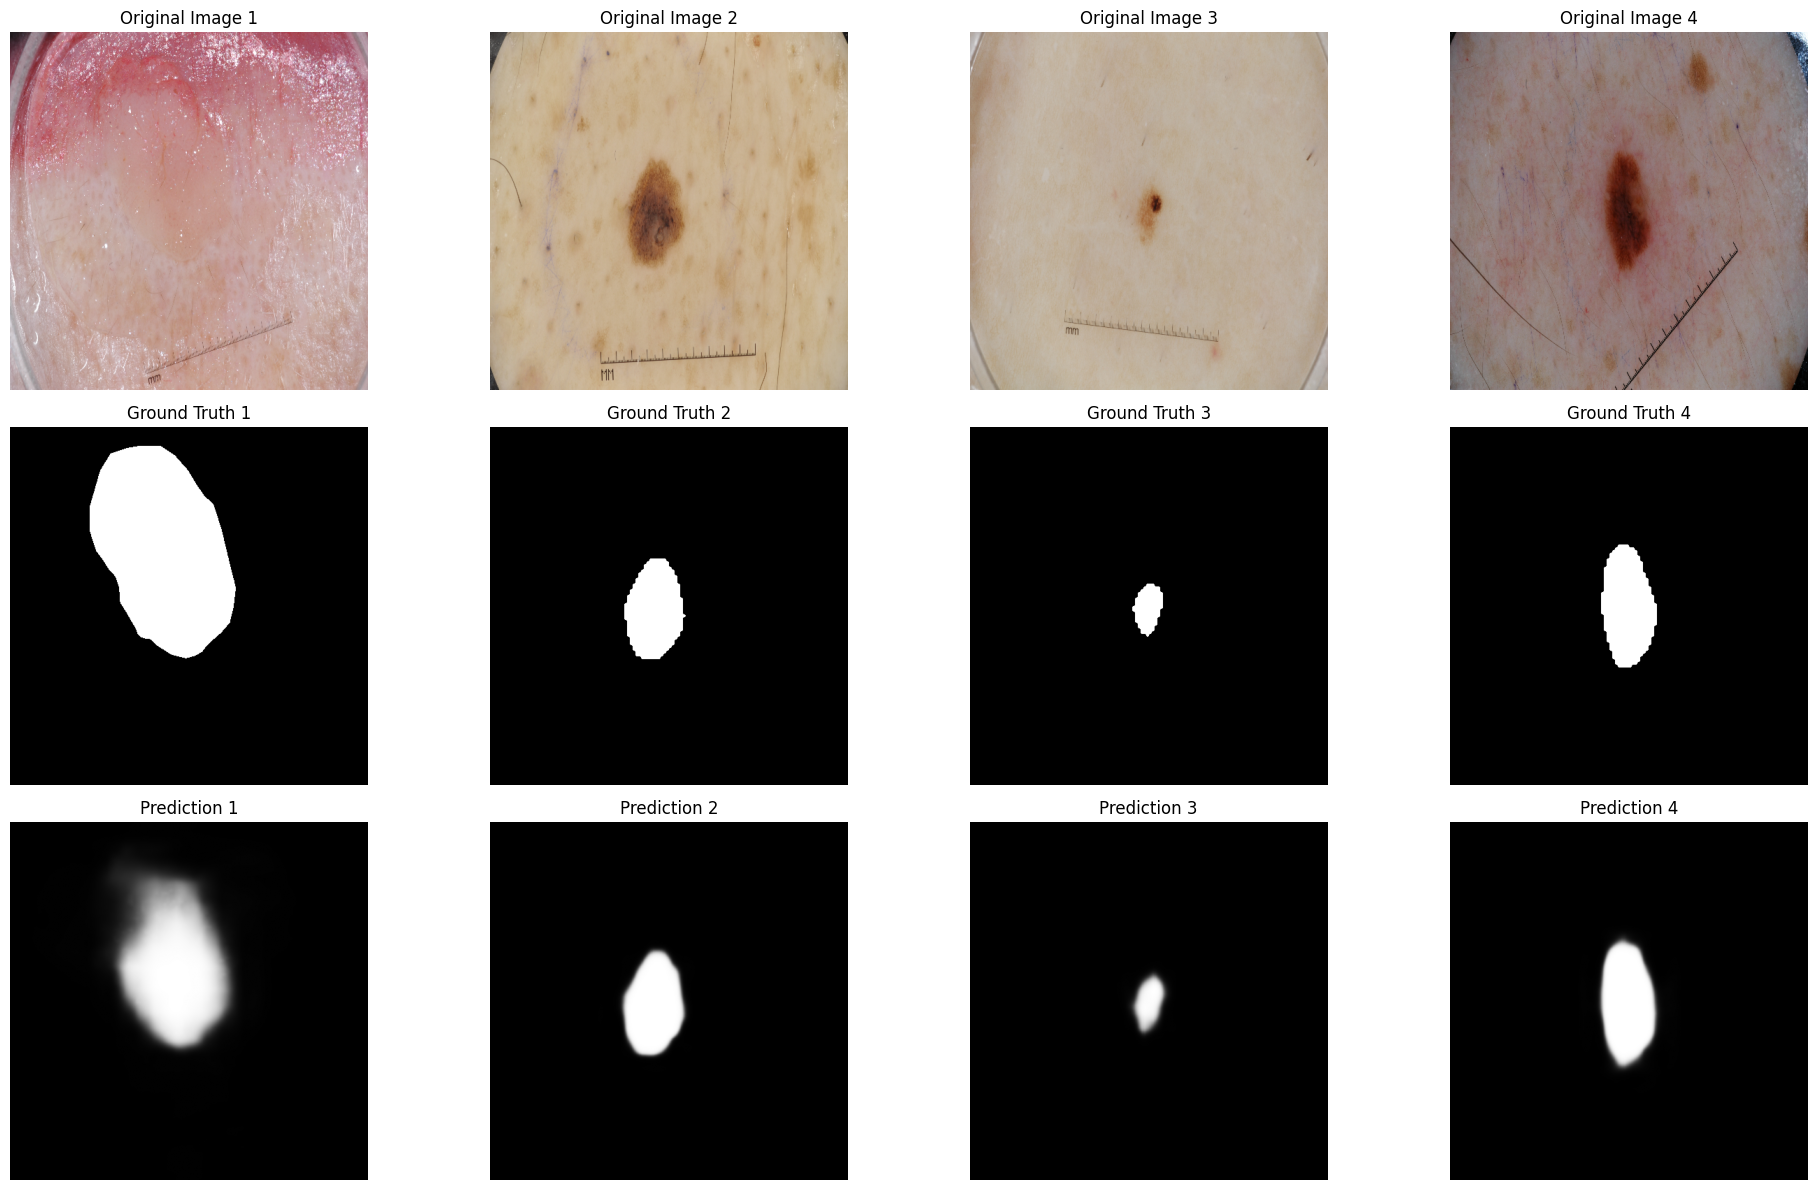

U-Net predictions:


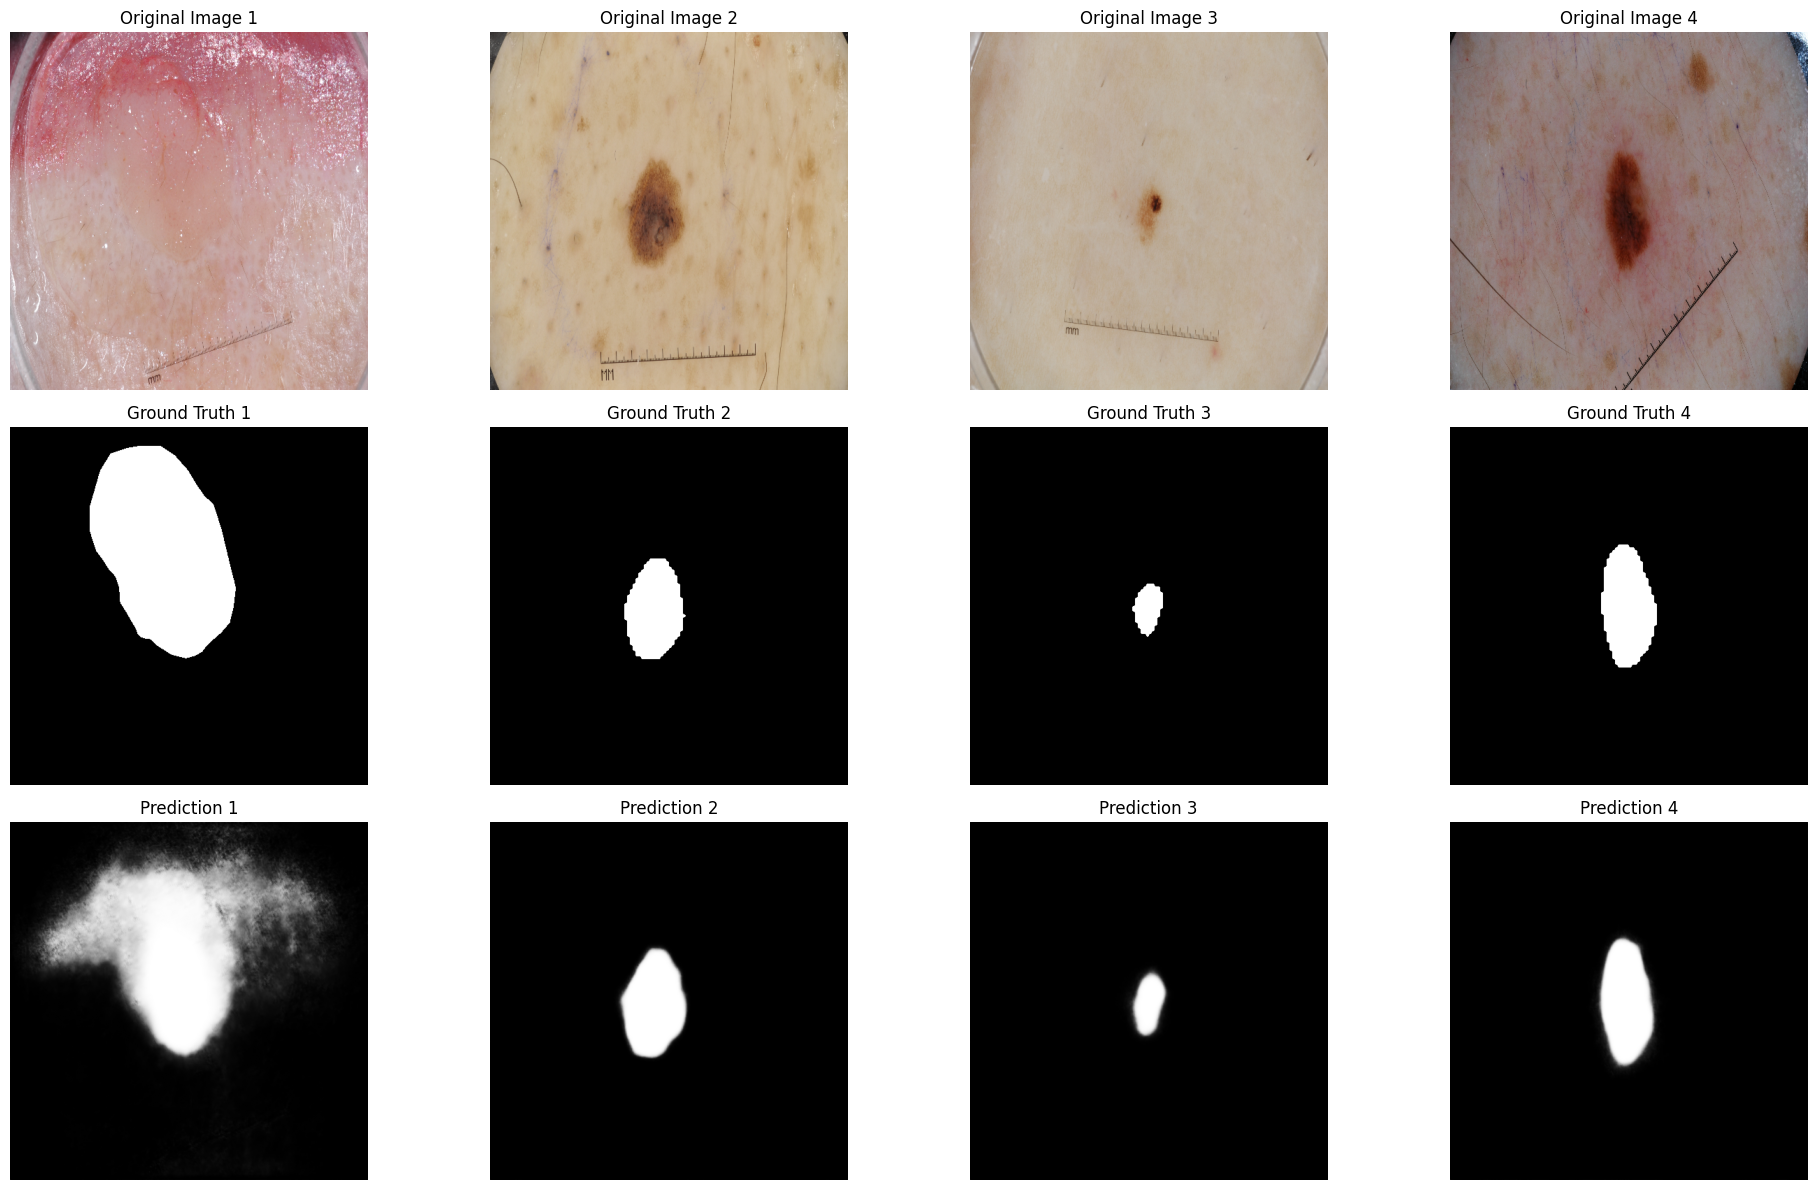

DeepLabV3+ predictions:


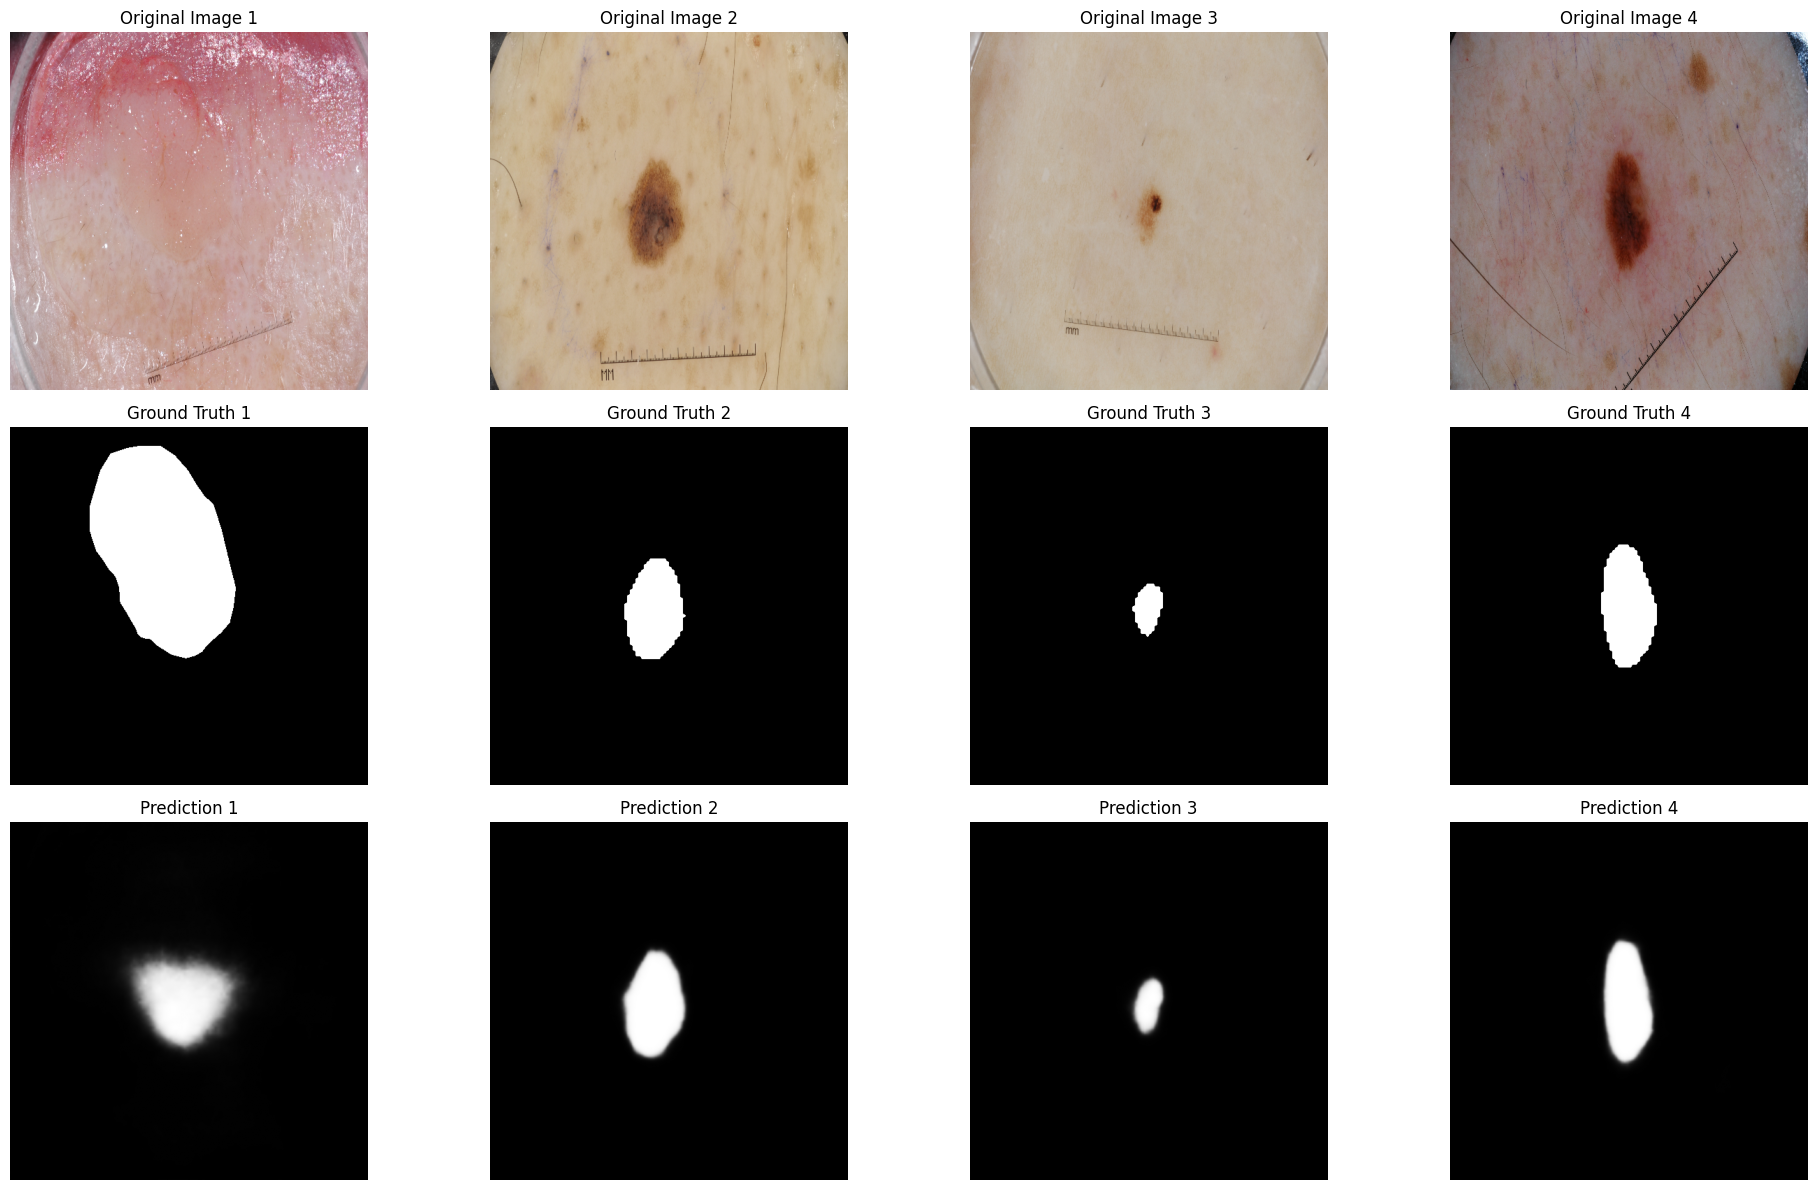

In [ ]:
def visualize_predictions(model, dataset, num_samples=4):
    model.eval()
    fig, axes = plt.subplots(3, num_samples, figsize=(20, 12))
    
    with torch.no_grad():
        for i in range(num_samples):
            # Get sample
            image, mask = dataset[i]
            image_input = image.unsqueeze(0).to(device)
            
            # Predict
            prediction = model(image_input)
            prediction = prediction.squeeze().cpu().numpy()
            
            # Denormalize image for visualization
            img_denorm = image.clone()
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            img_denorm = img_denorm * std + mean
            img_denorm = torch.clamp(img_denorm, 0, 1)
            img_denorm = img_denorm.permute(1, 2, 0).numpy()
            
            # Plot
            axes[0, i].imshow(img_denorm)
            axes[0, i].set_title(f'Original Image {i+1}')
            axes[0, i].axis('off')
            
            axes[1, i].imshow(mask.squeeze(), cmap='gray')
            axes[1, i].set_title(f'Ground Truth {i+1}')
            axes[1, i].axis('off')
            
            axes[2, i].imshow(prediction, cmap='gray')
            axes[2, i].set_title(f'Prediction {i+1}')
            axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize predictions from all models
print("Visualizing predictions from all models...")

# Visualize SegFormer predictions
print("SegFormer predictions:")
visualize_predictions(segformer_model, test_dataset, num_samples=4)

# Visualize U-Net predictions
print("U-Net predictions:")
visualize_predictions(unet_model, test_dataset, num_samples=4)

# Visualize DeepLabV3+ predictions
print("DeepLabV3+ predictions:")
visualize_predictions(deeplabv3_model, test_dataset, num_samples=4)

## 10. Hướng dẫn sử dụng và Demo

In [ ]:
# Demo: Load và test một model đã train
def load_and_test_model(model_class, model_path, test_image_path):
    """
    Load model và test trên một ảnh
    """
    # Initialize model
    model = model_class()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    
    # Load và preprocess image
    image = cv2.imread(test_image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (512, 512))
    
    # Apply transforms
    transform = A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    
    transformed = transform(image=image)
    image_tensor = transformed['image'].unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        prediction = model(image_tensor)
        prediction = prediction.squeeze().cpu().numpy()
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(prediction, cmap='gray')
    axes[1].set_title('Predicted Mask')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return prediction

# Example usage:
# prediction = load_and_test_model(
#     SegFormerModel, 
#     'models/segformer_model.pth', 
#     'path/to/test/image.jpg'
# )

# Load và test tất cả models:
# segformer_pred = load_and_test_model(SegFormerModel, 'models/segformer_model.pth', 'test_image.jpg')
# vit_seg_pred = load_and_test_model(ViTSegmentation, 'models/vit_segmentation_model.pth', 'test_image.jpg')
# unet_pred = load_and_test_model(TimmUNet, 'models/unet_efficientnet_model.pth', 'test_image.jpg')
# unet_vit_pred = load_and_test_model(ViTUNet, 'models/unet_vit_model.pth', 'test_image.jpg')
# deeplabv3_pred = load_and_test_model(TimmDeepLabV3Plus, 'models/deeplabv3_resnet_model.pth', 'test_image.jpg')

## 11. So sánh Performance các Models

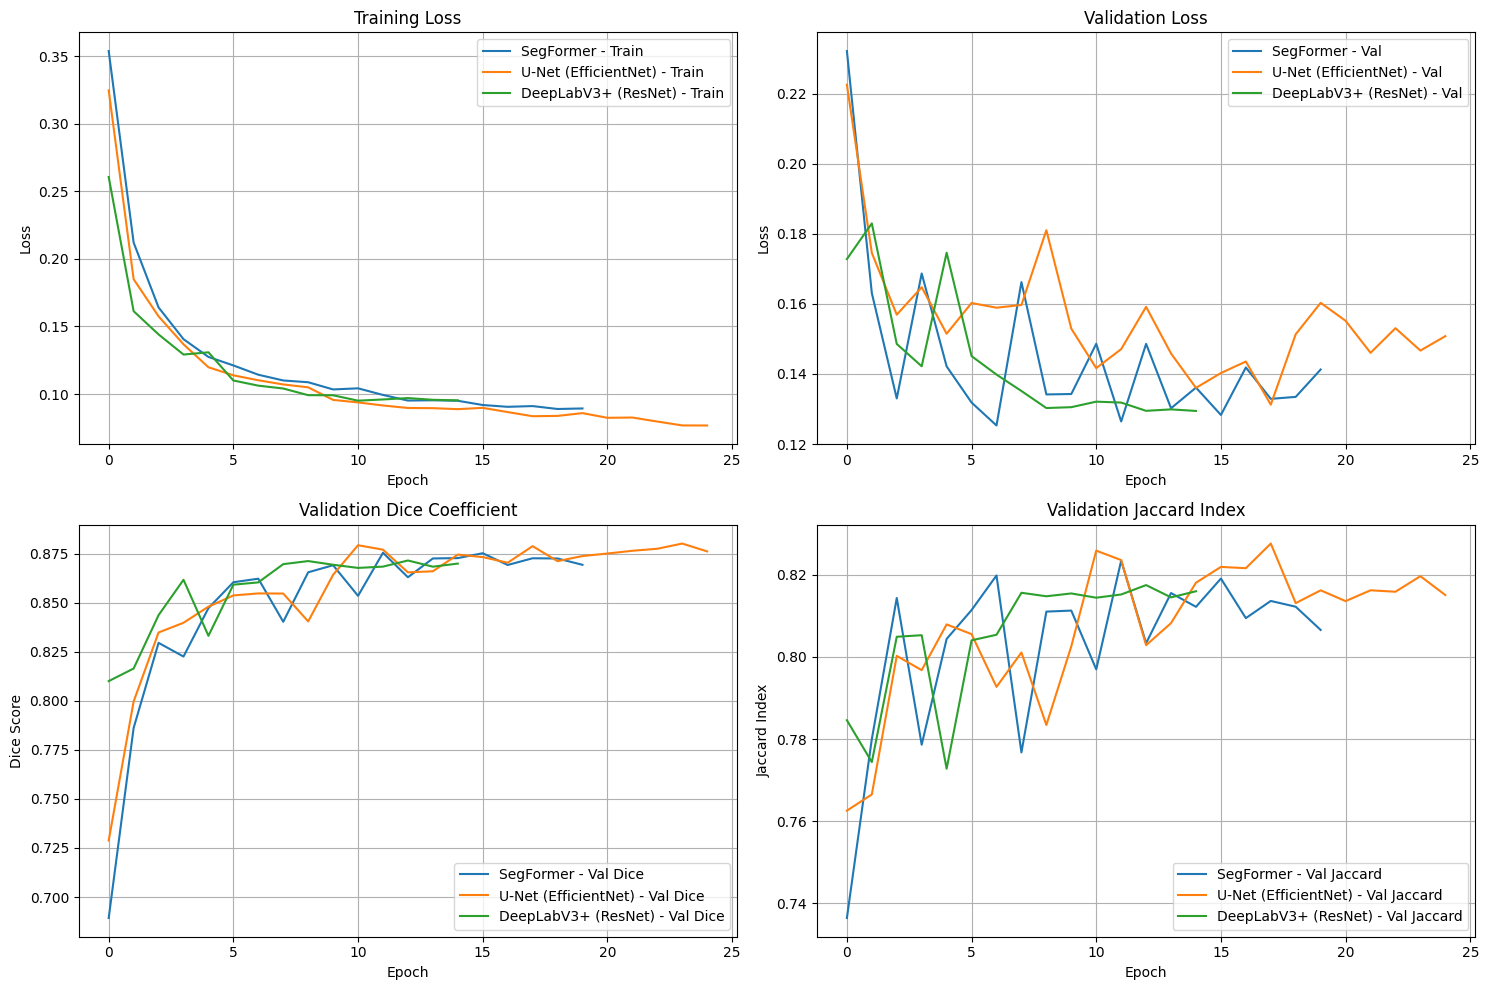

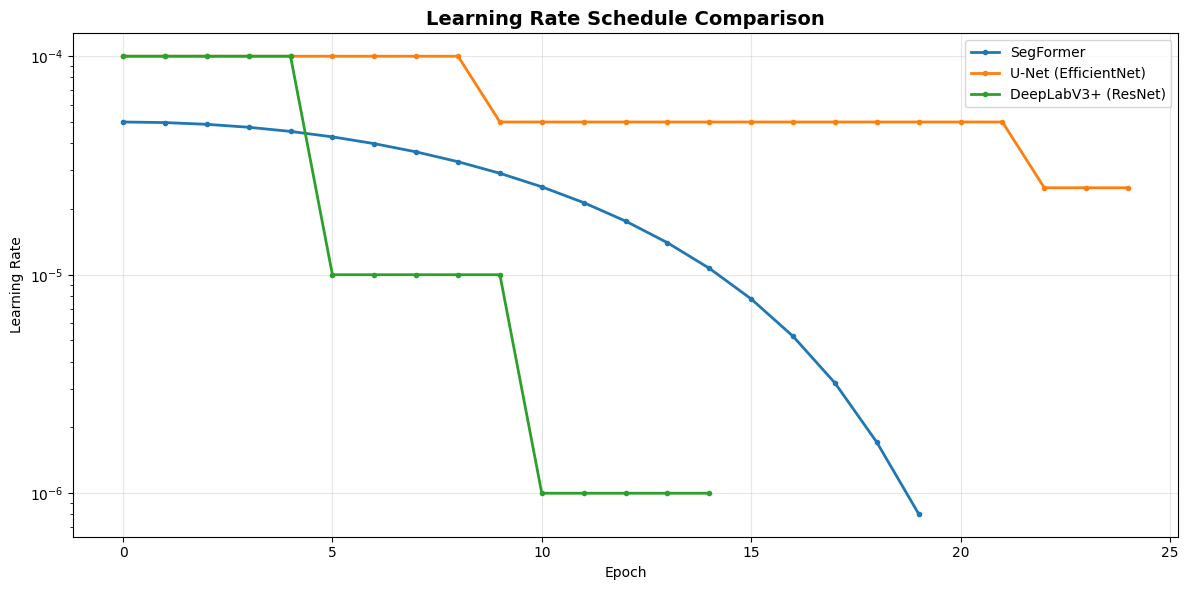

In [ ]:
# Tạo bảng so sánh performance
def create_performance_table(model_results):
    """
    model_results: dict với format {
        'model_name': {'iou': value, 'dice': value, 'params': value}
    }
    """
    df = pd.DataFrame(model_results).T
    df = df.round(4)
    
    # Styling
    styled_df = df.style.highlight_max(subset=['iou', 'dice'], color='lightgreen')
    styled_df = styled_df.highlight_min(subset=['params'], color='lightblue')
    
    return styled_df

# Create performance comparison table using actual results
performance_table = create_performance_table(model_results)
display(performance_table)

# Plot training histories comparison
histories = [segformer_history, unet_history, deeplabv3_history]
model_names = ['SegFormer', 'U-Net (EfficientNet)', 'DeepLabV3+ (ResNet)']
plot_training_history(histories, model_names)

# Plot learning rate schedules
plot_learning_rate_schedule(histories, model_names)